In [1]:
import operator
import os

import pandas as pd
import pytz

from qstrader.alpha_model.alpha_model import AlphaModel
from qstrader.alpha_model.fixed_signals import FixedSignalsAlphaModel
from qstrader.asset.equity import Equity
from qstrader.asset.universe.dynamic import DynamicUniverse
from qstrader.asset.universe.static import StaticUniverse
from qstrader.signals.momentum import MomentumSignal
from qstrader.signals.signals_collection import SignalsCollection
from qstrader.data.backtest_data_handler import BacktestDataHandler
from qstrader.data.daily_bar_csv import CSVDailyBarDataSource
from qstrader.statistics.tearsheet import TearsheetStatistics
from qstrader.trading.backtest import BacktestTradingSession



In [2]:

class TopNMomentumAlphaModel(AlphaModel):

    def __init__(
        self, signals, mom_lookback, mom_top_n, universe, data_handler
    ):
        """
        Initialise the TopNMomentumAlphaModel

        Parameters
        ----------
        signals : `SignalsCollection`
            The entity for interfacing with various pre-calculated
            signals. In this instance we want to use 'momentum'.
        mom_lookback : `integer`
            The number of business days to calculate momentum
            lookback over.
        mom_top_n : `integer`
            The number of assets to include in the portfolio,
            ranking from highest momentum descending.
        universe : `Universe`
            The collection of assets utilised for signal generation.
        data_handler : `DataHandler`
            The interface to the CSV data.

        Returns
        -------
        None
        """
        self.signals = signals
        self.mom_lookback = mom_lookback
        self.mom_top_n = mom_top_n
        self.universe = universe
        self.data_handler = data_handler

    def _highest_momentum_asset(
        self, dt
    ):
        """
        Calculates the ordered list of highest performing momentum
        assets restricted to the 'Top N', for a particular datetime.

        Parameters
        ----------
        dt : `pd.Timestamp`
            The datetime for which the highest momentum assets
            should be calculated.

        Returns
        -------
        `list[str]`
            Ordered list of highest performing momentum assets
            restricted to the 'Top N'.
        """
        assets = self.signals['momentum'].assets
        
        # Calculate the holding-period return momenta for each asset,
        # for the particular provided momentum lookback period
        all_momenta = {
            asset: self.signals['momentum'](
                asset, self.mom_lookback
            ) for asset in assets
        }

        # Obtain a list of the top performing assets by momentum
        # restricted by the provided number of desired assets to
        # trade per month
        return [
            asset[0] for asset in sorted(
                all_momenta.items(),
                key=operator.itemgetter(1),
                reverse=True
            )
        ][:self.mom_top_n]

    def _generate_signals(
        self, dt, weights
    ):
        """
        Calculate the highest performing momentum for each
        asset then assign 1 / N of the signal weight to each
        of these assets.

        Parameters
        ----------
        dt : `pd.Timestamp`
            The datetime for which the signal weights
            should be calculated.
        weights : `dict{str: float}`
            The current signal weights dictionary.

        Returns
        -------
        `dict{str: float}`
            The newly created signal weights dictionary.
        """
        top_assets = self._highest_momentum_asset(dt)
        for asset in top_assets:
            weights[asset] = 1.0 / self.mom_top_n
        return weights

    def __call__(
        self, dt
    ):
        """
        Calculates the signal weights for the top N
        momentum alpha model, assuming that there is
        sufficient data to begin calculating momentum
        on the desired assets.

        Parameters
        ----------
        dt : `pd.Timestamp`
            The datetime for which the signal weights
            should be calculated.

        Returns
        -------
        `dict{str: float}`
            The newly created signal weights dictionary.
        """
        assets = self.universe.get_assets(dt)
        weights = {asset: 0.0 for asset in assets}

        # Only generate weights if the current time exceeds the
        # momentum lookback period
        if self.signals.warmup >= self.mom_lookback:
            weights = self._generate_signals(dt, weights)
        return weights



In [3]:



os.environ["QSTRADER_CSV_DATA_DIR"] = '/Users/snk/pcode/archive/qstrader/data'

# Duration of the backtest

start_dt = pd.Timestamp('2003-09-30 09:30:00', tz='America/New_York')
burn_in_dt = pd.Timestamp('2004-09-30 09:30:00', tz='America/New_York')
end_dt = pd.Timestamp('2019-12-31 16:00:00', tz='America/New_York')



# Model parameters
mom_lookback = 126  # Six months worth of business days
mom_top_n = 3  # Number of assets to include at any one time

# Construct the symbols and assets necessary for the backtest
# This utilises the SPDR US sector ETFs, all beginning with XL
strategy_symbols = ['XL%s' % sector for sector in "BCEFIKPUVY"]
assets = ['EQ:%s' % symbol for symbol in strategy_symbols]

# As this is a dynamic universe of assets (XLC is added later)
# we need to tell QSTrader when XLC can be included. This is
# achieved using an asset dates dictionary
asset_dates = {asset: start_dt for asset in assets}
asset_dates['EQ:XLC'] = pd.Timestamp('2018-06-18 00:00:00', tz=pytz.UTC)
strategy_universe = DynamicUniverse(asset_dates)

# To avoid loading all CSV files in the directory, set the
# data source to load only those provided symbols
csv_dir = os.environ.get('QSTRADER_CSV_DATA_DIR', '.')
strategy_data_source = CSVDailyBarDataSource(csv_dir, Equity, csv_symbols=strategy_symbols)
strategy_data_handler = BacktestDataHandler(strategy_universe, data_sources=[strategy_data_source])

# Generate the signals (in this case holding-period return based
# momentum) used in the top-N momentum alpha model
momentum = MomentumSignal(start_dt, strategy_universe, lookbacks=[mom_lookback])
signals = SignalsCollection({'momentum': momentum}, strategy_data_handler)

# Generate the alpha model instance for the top-N momentum alpha model
strategy_alpha_model = TopNMomentumAlphaModel(
    signals, mom_lookback, mom_top_n, strategy_universe, strategy_data_handler
)

# Construct the strategy backtest and run it
strategy_backtest = BacktestTradingSession(
    start_dt,
    end_dt,
    strategy_universe,
    strategy_alpha_model,
    signals=signals,
    rebalance='end_of_month',
    long_only=True,
    cash_buffer_percentage=0.01,
    burn_in_dt=burn_in_dt,
    data_handler=strategy_data_handler
)
strategy_backtest.run()


Loading CSV files into DataFrames...
Loading CSV file for symbol 'EQ:XLB'...
Loading CSV file for symbol 'EQ:XLC'...
Loading CSV file for symbol 'EQ:XLE'...
Loading CSV file for symbol 'EQ:XLF'...
Loading CSV file for symbol 'EQ:XLI'...
Loading CSV file for symbol 'EQ:XLK'...
Loading CSV file for symbol 'EQ:XLP'...
Loading CSV file for symbol 'EQ:XLU'...
Loading CSV file for symbol 'EQ:XLV'...
Loading CSV file for symbol 'EQ:XLY'...
Loading pricing in CSV files...
Loading CSV file for symbol 'EQ:XLB'...
Loading CSV file for symbol 'EQ:XLC'...
Loading CSV file for symbol 'EQ:XLE'...
Loading CSV file for symbol 'EQ:XLF'...
Loading CSV file for symbol 'EQ:XLI'...
Loading CSV file for symbol 'EQ:XLK'...
Loading CSV file for symbol 'EQ:XLP'...
Loading CSV file for symbol 'EQ:XLU'...
Loading CSV file for symbol 'EQ:XLV'...
Loading CSV file for symbol 'EQ:XLY'...
Initialising simulated broker "Backtest Simulated Broker Account"...
(2003-09-30 09:30:00-04:00) - portfolio creation: Portfolio "0

Loading CSV files into DataFrames...
Loading CSV file for symbol 'EQ:SPY'...
Loading pricing in CSV files...
Loading CSV file for symbol 'EQ:SPY'...
Initialising simulated broker "Backtest Simulated Broker Account"...
(2004-09-30 09:30:00-04:00) - portfolio creation: Portfolio "000001" created at broker "Backtest Simulated Broker Account"
(2004-09-30 09:30:00-04:00) - subscription: 1000000.00 subscribed to portfolio "000001"
Beginning backtest simulation...
(2004-09-30 09:30:00-04:00) - market_open
(2004-09-30 09:30:00-04:00) - trading logic and rebalance
(2004-09-30 09:30:00-04:00) - target weights: {'EQ:SPY': 1.0}
(2004-09-30 09:30:00-04:00) - submitted order: EQ:SPY, qty: 8874
(2004-09-30 09:30:00-04:00) - executed order: EQ:SPY, qty: 8874, price: 111.55, consideration: 989895.00, commission: 0.00, total: 989895.00
(2004-09-30 16:00:00-04:00) - market_close
(2004-10-01 09:30:00-04:00) - market_open
(2004-10-01 16:00:00-04:00) - market_close
(2004-10-04 09:30:00-04:00) - market_open


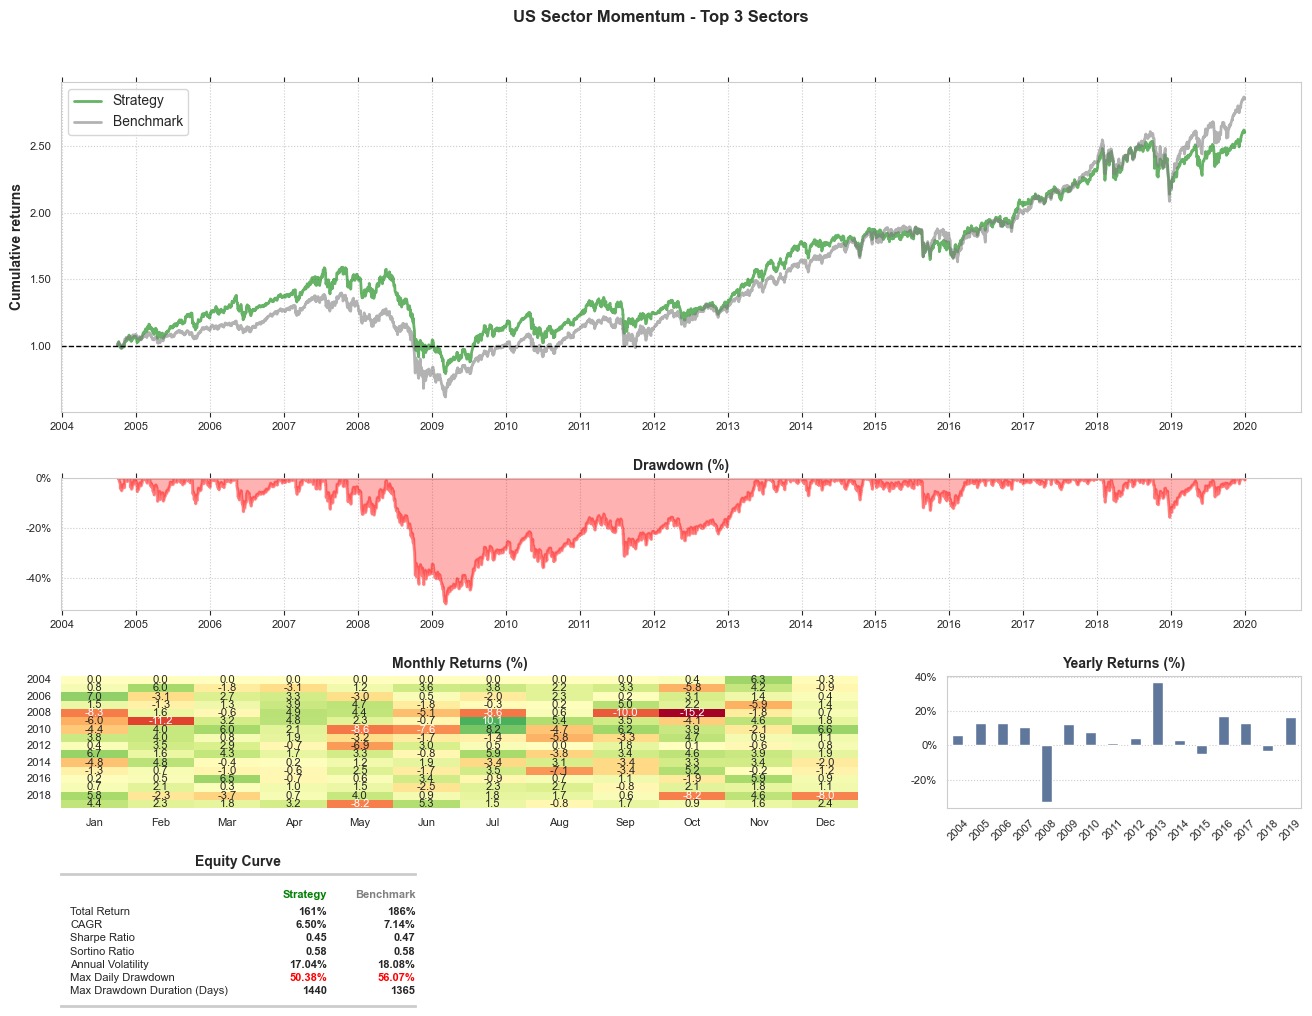

In [4]:

# Construct benchmark assets (buy & hold SPY)
benchmark_symbols = ['SPY']
benchmark_assets = ['EQ:SPY']
benchmark_universe = StaticUniverse(benchmark_assets)
benchmark_data_source = CSVDailyBarDataSource(csv_dir, Equity, csv_symbols=benchmark_symbols)
benchmark_data_handler = BacktestDataHandler(benchmark_universe, data_sources=[benchmark_data_source])

# Construct a benchmark Alpha Model that provides
# 100% static allocation to the SPY ETF, with no rebalance
benchmark_alpha_model = FixedSignalsAlphaModel({'EQ:SPY': 1.0})
benchmark_backtest = BacktestTradingSession(
    burn_in_dt,
    end_dt,
    benchmark_universe,
    benchmark_alpha_model,
    rebalance='buy_and_hold',
    long_only=True,
    cash_buffer_percentage=0.01,
    data_handler=benchmark_data_handler
)
benchmark_backtest.run()

# Performance Output
tearsheet = TearsheetStatistics(
    strategy_equity=strategy_backtest.get_equity_curve(),
    benchmark_equity=benchmark_backtest.get_equity_curve(),
    title='US Sector Momentum - Top 3 Sectors'
)
tearsheet.plot_results()
